# YOLOX: Exceeding YOLO Series in 2021 - A Quick Review
---

## Technical code

First, we import required libraries


*   Gdrive libs for assets
*   pytube to demo video classification
*   Matplotlib fo image manipulation




In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
!pip install pytube3
from pytube import YouTube
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

Second, we clone the repository and one of the benchmark models to analyze. 


*Please note the benchmark is saved in GDrive for ease of access. Kindly authenticate GDrive with any account to get access of the benchmark model file*

In [ ]:
%cd /content
!git clone https://github.com/Megvii-BaseDetection/YOLOX.git
%cd YOLOX
!pip3 install -U pip
!pip3 install -r requirements.txt
!pip3 install -v -e . 

In [ ]:
%cd /content
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1hX6MD5pWtyx44qwb8yU9Ww1gHsgJX2Sj'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('yolox_s.pth.tar')

In [ ]:
# Showing a quick demo on dog.jpg to check if everything is okay
%cd /content/YOLOX/
!python tools/demo.py image -n yolox-s -c /content/yolox_s.pth.tar --path assets/dog.jpg --conf 0.3 --nms 0.65 --tsize 640 --save_result

sample_dog_img = mpimg.imread(os.path.join(
    '/content/YOLOX/YOLOX_outputs/yolox_s/vis_res',
    os.listdir('/content/YOLOX/YOLOX_outputs/yolox_s/vis_res')[0],
    'dog.jpg'))

imgplot = plt.imshow(sample_dog_img)

Optional: check this quick demo over video

In [ ]:
yt = YouTube("https://www.youtube.com/watch?v=9wTg_7kf0h0&ab_channel=pr3ttykitty1337")
yt.streams.get_highest_resolution().download('./cat_on_ladder.mp4')

In [ ]:
%cd /content/YOLOX/
!python tools/demo.py video -n yolox-s -c /content/yolox_s.pth.tar --path /content/cat_on_ladder.mp4/Cat\ On\ Ladder.mp4 --conf 0.3 --nms 0.65 --tsize 640 --save_result

Installing COCO as our training dataset. I chose COCO for ease of installation and setup

In [ ]:
# installing apex for training
git clone https://github.com/NVIDIA/apex
cd apex
pip3 install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [ ]:
%cd /content
!mkdir -p datasets/vtfs/COCO
%cd datasets/vtfs/COCO
!wget https://github.com/makerhanoi/via-datasets/releases/download/v1.0/via-trafficsign-coco-20210321.zip -O via-trafficsign-coco-20210321.zip
!unzip via-trafficsign-coco-20210321.zip -d .

In [ ]:
# working on yolox-s as it is the middle ground between training time and accuracy
# commented -d parameter specifices number of gpu to train on. DEFAULT: all GPUs
# -b total batch size across all gpus. recommended 8 * number of gpus
!export YOLOX_DATADIR=datasets/vtfs/
%cd /content/YOLOX
!python3 tools/train.py -f nano_like.py -b 8

In [ ]:
# quick evaluation of benchmark model
!python tools/eval.py -n yolox-s -c yolox_s.pth.tar -b 8 --conf 0.001

## Evaluation and Analysis


### Architecture advantages


1.   Anchor-free detection
2.   Decoupled head
3.   Advanced label assignment strategy: SimOTA
4.   Strong data augmentation: Mosaic, MixUp
5. optimal tradeoff between accuracy & performance which is more applicable to business (real-life) applications

#### Anchor-free: the main pro of YOLOX
The anchor-free approach suggested by the paper treats the object detection as a keypoint detection problem (like SIFT). This approach lowers complexity of the model, lowers complixties & number of predictions, and doesn't need specific configs or preferences of anchor boxes which limits generality of the model. The anchor mechanism also intoduces latency by moving data from GPU to CPU which is a major bottleneck

### Architecture Disadvantages



1.   fails in ocluded scenarios
2.   not as strong as older versions in lower light environments
3.   doesn't work very well with smaller objects



### Training

Sample training yielded mAP=~0.35 loss in the validation set of the COCO street signs dataset.

I expect this to be higher with larger objects

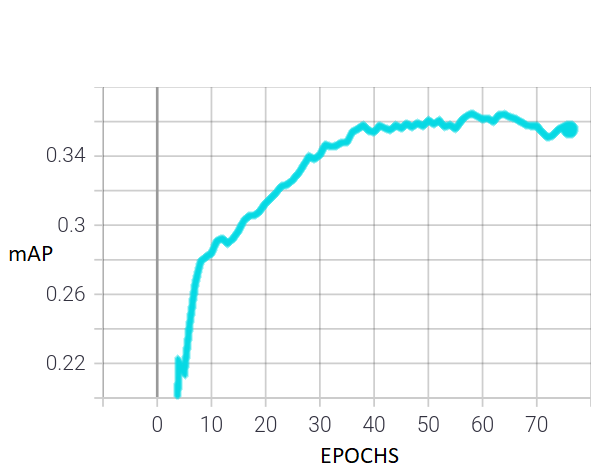